In [1]:
import torch, torchvision, os, matplotlib.pyplot as plt, pandas as pd, pathlib
from torch.nn import Sequential, Module, Linear, ReLU, CrossEntropyLoss, Conv2d, Flatten, MaxPool2d
from torch.optim import Adam, SGD
from torch import inference_mode
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, AutoAugment, Normalize, ToTensor, ToPILImage
# from tqdm.auto import tqdm
from timeit import default_timer as timer
from PIL import Image

In [2]:
train_csv = pd.read_csv("../data/train.csv")
train_csv

Unnamed: 0                                        file_name  label
0               0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1               1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2               2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3               3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4               4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1
...           ...                                              ...    ...
79945       79945  train_data/9283b107f6274279b6f15bbe77c523aa.jpg      0
79946       79946  train_data/4c6b17fe6dd743428a45773135a10508.jpg      1
79947       79947  train_data/1ccbf96d04e342fd9f629ad55466b29e.jpg      0
79948       79948  train_data/ff960b55f296445abb3c5f304b52e104.jpg      1
79949       79949  train_data/3abd1876472f4ec988aa78f76664fbd6.jpg      0

[79950 rows x 3 columns]

In [3]:
train_csv.label.value_counts()

label
1    39975
0    39975
Name: count, dtype: int64

In [4]:
train_csv = train_csv.drop(columns=["Unnamed: 0"])
train_csv

file_name  label
0      train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1      train_data/041be3153810433ab146bc97d5af505c.jpg      0
2      train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3      train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4      train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1
...                                                ...    ...
79945  train_data/9283b107f6274279b6f15bbe77c523aa.jpg      0
79946  train_data/4c6b17fe6dd743428a45773135a10508.jpg      1
79947  train_data/1ccbf96d04e342fd9f629ad55466b29e.jpg      0
79948  train_data/ff960b55f296445abb3c5f304b52e104.jpg      1
79949  train_data/3abd1876472f4ec988aa78f76664fbd6.jpg      0

[79950 rows x 2 columns]

In [5]:
train_csv = train_csv.drop_duplicates()
train_csv = train_csv.dropna()
train_csv.count()

file_name    79950
label        79950
dtype: int64

In [6]:
train_csv[train_csv["file_name"].str.contains('train_data_v2')]

Empty DataFrame
Columns: [file_name, label]
Index: []

In [7]:
CLASSES = ["ai_generated", "original"]
CLASS_TO_IDX = {"ai_generated": 0, "original": 1}
BATCH_SIZE = 32
NUM_WORKERS = 1
# os.cpu_count()
DEVICE = 'mps' if torch.backends.mps.is_available() else 'cpu'

NUM_WORKERS, DEVICE

(1, 'mps')

In [8]:
DEFAULT_TRANSFORMER = Compose([
    Resize(size=(64, 64)),
    ToTensor(),
    # Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class CustomImageDataset(Dataset):
    def __init__(self, image_path_with_lables: pd.DataFrame, images_path="../data/", transformer=DEFAULT_TRANSFORMER):
        super(CustomImageDataset, self).__init__()
        self.image_path_with_lables = image_path_with_lables
        self.images_path = images_path
        self.transformer = transformer

    classes = CLASSES
    class_to_idx = CLASS_TO_IDX

    def __len__(self):
        return self.image_path_with_lables.shape[0]

    def load_image(self, path):
        image = Image.open(self.images_path + path)
        if self.transformer is None:
            return image
        return self.transformer(image)

    def __getitem__(self, index):
        image_path, label = self.image_path_with_lables.iloc[index]
        return self.load_image(image_path), label

In [9]:
dataset = CustomImageDataset(train_csv)

Image Id: 72665 | Label: 0


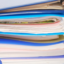

In [10]:
import random

choise = random.randint(0, train_csv.shape[0])
image, label = dataset[choise]

print(f"Image Id: {choise} | Label: {label}")

ToPILImage()(image)

In [11]:
TOTAL_LEN = len(dataset)
VAL_LEN = int(TOTAL_LEN * 0.1)
TRAIN_LEN = int(TOTAL_LEN - VAL_LEN)

TOTAL_LEN, TRAIN_LEN, VAL_LEN

(79950, 71955, 7995)

In [12]:
train_dataset, val_dataset = random_split(dataset, lengths=[TRAIN_LEN, VAL_LEN])
len(train_dataset), len(val_dataset)

(71955, 7995)

In [13]:
def filter_condition(inputs):
    x, y = inputs
    # print(x.shape[0])
    return x.shape[0] == 3
    
def my_collate_fn(batch):
    batch = list(filter(filter_condition, batch))
    return torch.utils.data.dataloader.default_collate(batch)      

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=my_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=my_collate_fn)

train_dataloader

In [16]:
x, y = next(iter(val_dataloader))
x.shape, y

(torch.Size([32, 3, 64, 64]),
 tensor([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
         0, 0, 1, 1, 0, 1, 1, 1]))

In [17]:
class AIGeneratedImageClassification(Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super(AIGeneratedImageClassification, self).__init__()
        self.conv_layer = Sequential(
            Conv2d(input_shape, hidden_units, kernel_size=3),
            ReLU(),
            Conv2d(hidden_units, hidden_units, kernel_size=3),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2)
        )
        self.feed_forward = Sequential(
            Flatten(),
            Linear(hidden_units * 30 ** 2, 2),
            # Linear(5, output_shape)
        )

    def forward(self, inputs):
        # x = self.conv_layer(inputs)
        # print(x.shape)
        # x = self.feed_forward(x)
        # print(x.shape)
        # return x
        return self.feed_forward(self.conv_layer(inputs))

In [18]:
model = AIGeneratedImageClassification(3, 10, len(CLASSES)).to(DEVICE)
model

AIGeneratedImageClassification(
  (conv_layer): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (feed_forward): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9000, out_features=2, bias=True)
  )
)

In [19]:
loss_fn = CrossEntropyLoss()
optimizer = Adam(params=model.parameters())

In [20]:
EPOCHS = 2

history = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

train_start = timer()

for epoch in range(EPOCHS):
    epoch_start = timer()
    
    train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0

    model.train()
    
    for batch, (train_x, train_y) in enumerate(train_dataloader):
        train_x, train_y = train_x.to(DEVICE), train_y.to(DEVICE)
        
        train_preds = model(train_x)

        loss = loss_fn(train_preds, train_y)

        train_loss += loss
        train_acc += (torch.argmax(torch.softmax(train_preds, dim=1), dim=1) == train_y).sum().item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 700 == 0:
            print(f"Epoch: {epoch} | Batch: {batch} | Train Loss: {train_loss / (batch + 1)} | Train Accuracy: {train_acc / ((batch + 1) * BATCH_SIZE)}")
    
    train_acc /= len(train_dataset)
    train_loss /= len(train_dataset)
    
    history["epoch"].append(epoch)
    history["train_acc"].append(train_acc)
    history["train_loss"].append(train_loss)

    model.eval()
    with inference_mode():
        for val_x, val_y in val_dataloader:
            val_x, val_y = val_x.to(DEVICE), val_y.to(DEVICE)
            
            val_preds = model(val_x)

            val_loss += loss_fn(val_preds, val_y)
            val_acc += (torch.argmax(torch.softmax(val_preds, dim=1), dim=1) == val_y).sum().item()
            
        val_acc /= len(val_dataset)
        val_loss /= len(val_dataset)

        history["val_acc"].append(val_acc)
        history["val_loss"].append(val_loss)

        epoch_end = timer()

        print(f"{epoch_end - epoch_start:.1f}/s Train Accuracy: {train_acc} | Train Loss: {train_loss} | Val Loss: {val_loss} | Val Accuracy: {val_acc}")

Epoch: 0 | Batch: 0 | Train Loss: 0.6925103664398193 | Train Accuracy: 0.53125
Epoch: 0 | Batch: 700 | Train Loss: 0.3901727795600891 | Train Accuracy: 0.49585413694721825
Epoch: 0 | Batch: 1400 | Train Loss: 0.3515382409095764 | Train Accuracy: 0.4995315845824411
Epoch: 0 | Batch: 2100 | Train Loss: 0.33227893710136414 | Train Accuracy: 0.49944966682532127
456.1/s Train Accuracy: 0.49896463067194774 | Train Loss: 0.010286704637110233 | Val Loss: 0.008425524458289146 | Val Accuracy: 0.4873045653533458
Epoch: 1 | Batch: 0 | Train Loss: 0.2195649892091751 | Train Accuracy: 0.53125
Epoch: 1 | Batch: 700 | Train Loss: 0.2851022183895111 | Train Accuracy: 0.49585413694721825
Epoch: 1 | Batch: 1400 | Train Loss: 0.2794328033924103 | Train Accuracy: 0.4995315845824411
Epoch: 1 | Batch: 2100 | Train Loss: 0.27468937635421753 | Train Accuracy: 0.49944966682532127
455.7/s Train Accuracy: 0.49896463067194774 | Train Loss: 0.008548380807042122 | Val Loss: 0.00788839440792799 | Val Accuracy: 0.4873

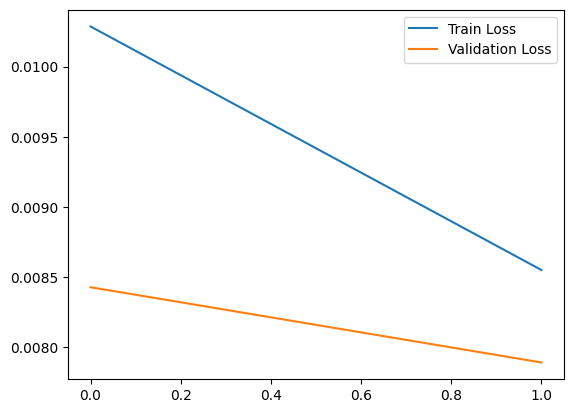

In [21]:
plt.plot(history["epoch"], [x.cpu().detach().numpy() for x in history["train_loss"]], label="Train Loss")
plt.plot(history["epoch"], [x.cpu().detach().numpy() for x in history["val_loss"]], label="Validation Loss")
plt.legend()
plt.show()

In [22]:
TEST_IMG_PATH = "../data/test_data_v2/0a4b8569dd9f4c1296c8e622b3bcbdf9.jpg"
img = torchvision.io.read_image(TEST_IMG_PATH)
img.shape

torch.Size([3, 512, 768])

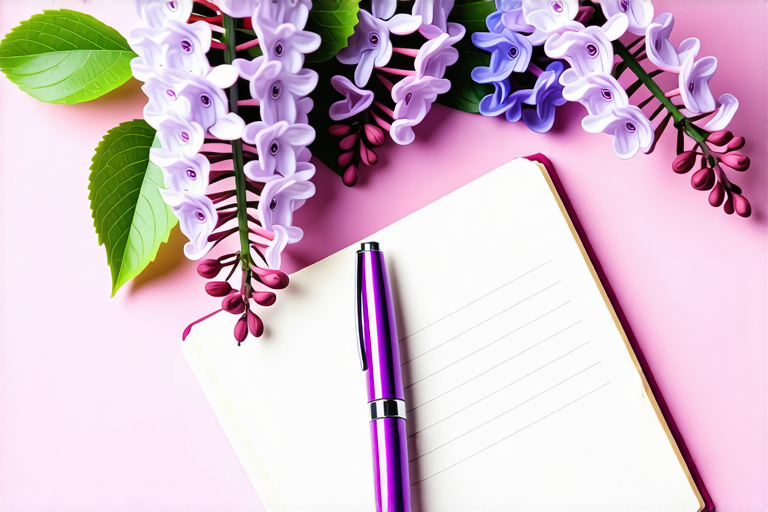

In [23]:
ToPILImage()(img)

torch.Size([3, 64, 64])


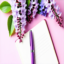

In [24]:
img = DEFAULT_TRANSFORMER(Image.open(TEST_IMG_PATH))
img = img.to(DEVICE)
print(img.shape)
ToPILImage()(img)

In [25]:
x, y = next(iter(val_dataloader))
x.shape, y

(torch.Size([32, 3, 64, 64]),
 tensor([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
         0, 0, 1, 1, 0, 1, 1, 1]))

In [29]:
x = x.to(DEVICE)
val_preds = model(x)
torch.argmax(torch.softmax(val_preds, dim=1), dim=1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='mps:0')